# Modelo para auxilio no diagnóstico de Pneumunia.

  O modelo utiliza a VGG18, os pesos da "imagenet" e uma camada FC com tres neurônios na ultima camada, classidicando a imagem com "Normal", "Pneumunia Bacteriana" ou "Pneumunia Viral".

  Modelo com aumento na damada desnse

  headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dropout(0.4)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

### reduzindo epocah para 15 bs 40
###MobileNetV3Large

## Importando e carregando bibliotecas básica

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import paths

## Criação da constantes do modelo

In [74]:
INIT_LR = 1e-3
EPOCHS = 15
BS = 40
np.random.seed(0)

## Carrega e tratamento inicial do dataset


In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')
workdir_path = '/content/drive/My Drive/TCC_IMAGENS'
os.chdir(workdir_path)

Mounted at /content/drive


In [4]:
from imutils import paths

dataset_path = 'dataset_imagens'
imagens_raioX  = list(paths.list_images(dataset_path))


In [5]:
#Tratamento das imagens, criação e carga das listas de imagens e labels
import cv2

imagens = []
labels = []

for imagem in imagens_raioX:

    label = imagem.split(os.path.sep)[-2]

   # Faz tratemento nos canais de cores das imagens e padroniza
   # o tamnho em 224 x 224
    imagem = cv2.imread(imagem)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (224, 224))

    imagens.append(imagem)
    labels.append(label)

## Análise exploratória

### Verificando o balanceomento do dataset

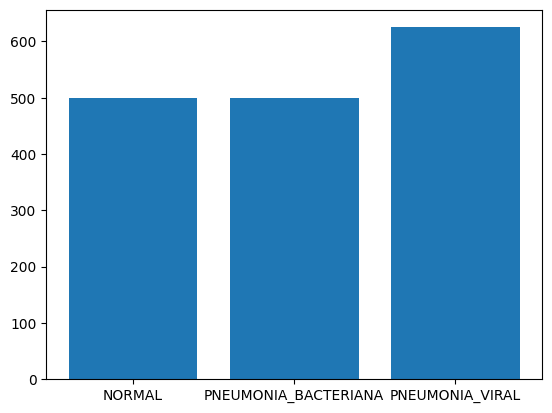

In [6]:
# Criua e carrega os dados quantitaivis da lista de imagens em um
# dicionario de dados para análise quantitativa das imagens

import matplotlib.pyplot as plt

dados = {'NORMAL': labels.count('NORMAL'), 'PNEUMONIA_BACTERIANA':labels.count('PNEUMONIA_BACTERIANA'), 'PNEUMONIA_VIRAL':labels.count('PNEUMONIA_VIRAL') }
plt.figure()
plt.bar(dados.keys(), dados.values())
plt.show()



### Preparando e visualizando imagem

In [7]:
# Converte as lista em matrizes, padronizando a escala de pixel na escala de
# [0, 255]

imagens_N = np.array(imagens) / 255.0
labels_N = np.array(labels)


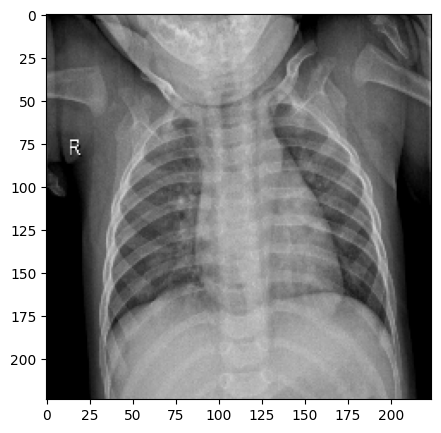

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(imagens_N[labels_N =='NORMAL'][1])
plt.show()

## Transformando os labels para numeral

In [9]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

lb = LabelBinarizer()
labels_b = lb.fit_transform(labels_N)

### Separação dos dados de treino, teste.

In [10]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(imagens_N, labels_b, test_size=0.20, stratify=labels_b, random_state=42)

## Rede Neural



### Importando e configurando a rede VGG16

In [75]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Input

baseModel = MobileNetV3Large (weights="imagenet", include_top=False,
                  input_tensor = Input(shape=(224, 224, 3)))

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Definindo a camadade Saida FC

In [76]:
# Construindo a camada FC
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(3, activation="softmax")(headModel)


### Montado a rede

In [77]:
model = Model(inputs=baseModel.input, outputs=headModel)

### Carregando e compilando o modelo

In [78]:
from tensorflow.keras.optimizers import Adam

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compilando o modelo...")
opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / EPOCHS )
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compilando o modelo...


### Verificando as saída da camada convolucional

In [79]:
#baseModel = InceptionV3(weights="imagenet", include_top=False,
                  #input_tensor=Input(shape=(224, 224, 3)))

f1 = baseModel.layers[1].output
f2 = baseModel.layers[2].output
f3 = baseModel.layers[4].output
f4 = baseModel.layers[5].output
feature_maps = Model(inputs=baseModel.input, outputs=[f1, f2, f3, f4])

In [80]:
y = np.argmax(trainY, axis=-1)

In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D

feat1, feat2, feat3, feat4 = feature_maps.predict(trainX[y==1][0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


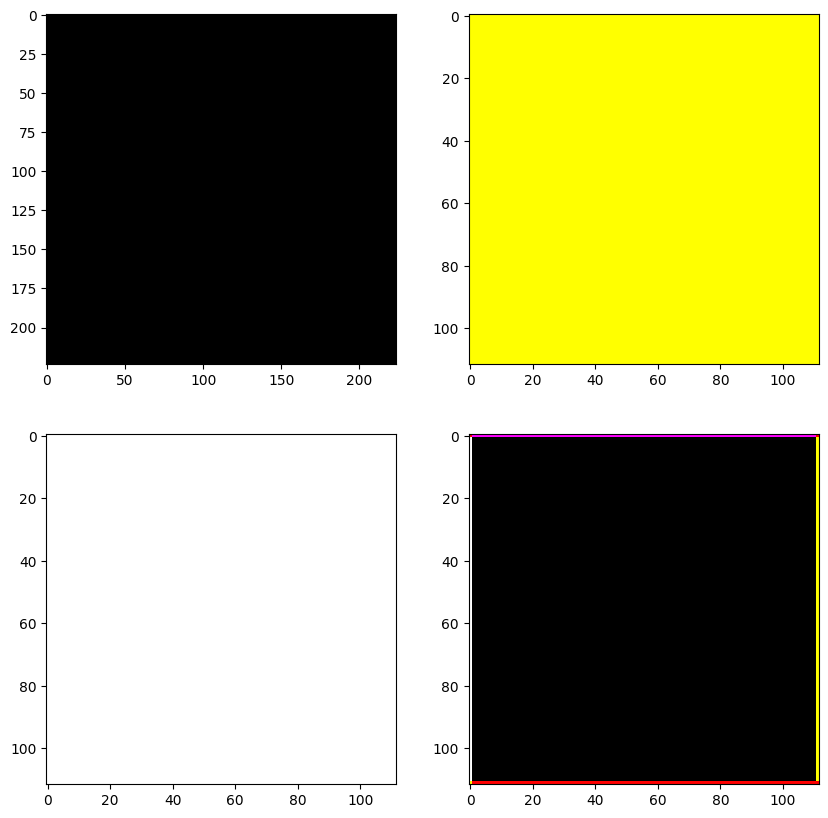

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(feat1[0, :, :, 0:3])
axs[0, 1].imshow(feat2[0, :, :, 6:9])
axs[1, 0].imshow(feat3[0, :, :, 0:3])
axs[1, 1].imshow(feat4[0, :, :, 3:6])
plt.show()

### Trainando a FC

In [83]:
print("[INFO] Trainando a FC...")
h = model.fit(trainX,
              trainY,
              batch_size = BS,
              steps_per_epoch=len(trainX) // BS,
              validation_split=0.2,
              epochs=EPOCHS)

[INFO] Trainando a FC...
Epoch 1/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3605 - loss: 0.6679

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 362ms/step - accuracy: 0.3599 - loss: 0.6639 - val_accuracy: 0.3538 - val_loss: 0.6451
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3799 - loss: 0.6387 - val_accuracy: 0.3538 - val_loss: 0.6437
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3681 - loss: 0.6380 - val_accuracy: 0.3538 - val_loss: 0.6432
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3887 - loss: 0.6330 - val_accuracy: 0.3538 - val_loss: 0.6424
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4012 - loss: 0.6387 - val_accuracy: 0.3538 - val_loss: 0.6451
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3918 - loss: 0.6367 - val_accuracy: 0.3538 - val_loss: 0.6384
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3850 - loss: 0.6348 - val_accuracy: 0.3538 - val_loss: 0.6413
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4128 - loss: 0.6314 - val_accuracy: 0.3538 - val_loss: 

## Analisando a performance do modelo

In [84]:
score = model.evaluate(testX, testY, verbose=0)

print('Test accuracy:', score[1])

Test accuracy: 0.6000000238418579


In [85]:
h.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [86]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("[INFO] Avaliando a Rede...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])


[INFO] Avaliando a Rede...
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step
                      precision    recall  f1-score   support

              NORMAL       0.70      0.82      0.76       100
PNEUMONIA_BACTERIANA       0.00      0.00      0.00       100
     PNEUMONIA_VIRAL       0.54      0.90      0.68       125

            accuracy                           0.60       325
           macro avg       0.41      0.57      0.48       325
        weighted avg       0.42      0.60      0.49       325



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gráficos: Loss, Accuracy e validação

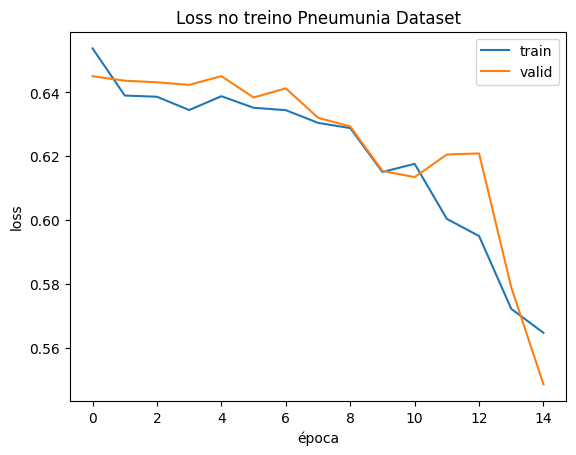

In [87]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='valid')
plt.title("Loss no treino Pneumunia Dataset")
plt.ylabel('loss')
plt.xlabel('época')
plt.legend()
plt.show()

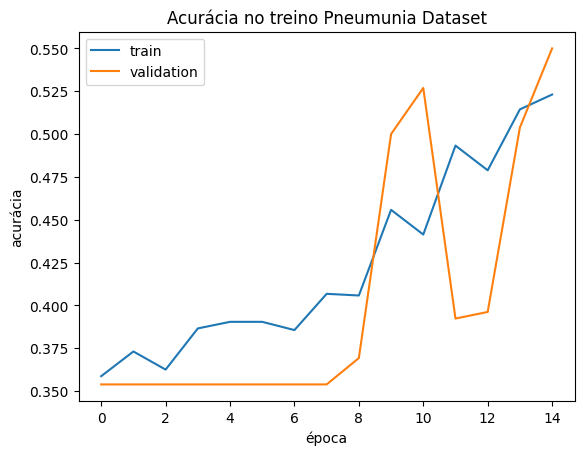

In [88]:
plt.plot(h.history['accuracy'], label='train')
plt.plot(h.history['val_accuracy'], label='validation')
plt.title("Acurácia no treino Pneumunia Dataset")
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend()
plt.show()

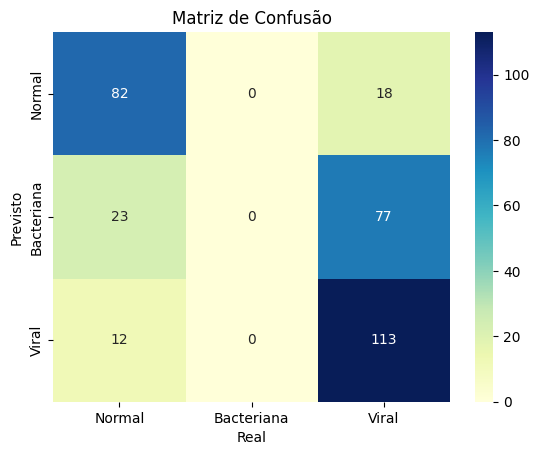

In [89]:
import seaborn as sns
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt=".0f", cmap='YlGnBu')
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Matriz de Confusão')

# Colocar os nomes
ax.xaxis.set_ticklabels(['Normal', 'Bacteriana','Viral'])
ax.yaxis.set_ticklabels(['Normal', 'Bacteriana','Viral'])
plt.show()